In [7]:
# Packages:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import umap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score
# packages for clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Questions of Interest:

- Can you predict a song's popularity by using its stats?
- Can songs be clustered or classified into genres using their specific stats?

## Data Cleaning and  Preprocessing

In [8]:
# Read in data
dfsongs = pd.read_csv('https://github.com/britt-anderson/Data/raw/main/spotify_songs.csv')


In [9]:
# Cleaning dfsongs

# Convert 'track_album_release_date' to datetime format
dfsongs['track_album_release_date'] = pd.to_datetime(dfsongs['track_album_release_date'])

# Extract the year from the date
dfsongs['year'] = dfsongs['track_album_release_date'].dt.year




In [10]:
# Drop the 5 missing values out of over 32,000

dfsongs = dfsongs.dropna()




In [11]:
# drop columns that don't add necessary information for our analysis
songs = dfsongs.drop(columns=['track_id', 'playlist_id', 'track_artist', 'track_album_id', 'track_album_name', 'track_album_release_date'])


In [12]:
# Specify columns to convert to factors
factor_columns = ['playlist_name', 'playlist_genre', 'playlist_subgenre', 'key', 'mode']

# Convert specified columns to the categorical data type
songs[factor_columns] = songs[factor_columns].astype('category')

# Convert 'year' to datetime without adding days
songs['year'] = pd.to_datetime(songs['year'].astype(str), format='%Y')


## EDA

In [10]:


# Display summary statistics of numeric columns
print(songs.describe())



       track_popularity  danceability        energy      loudness  \
count      32828.000000  32828.000000  32828.000000  32828.000000   
mean          42.483551      0.654850      0.698603     -6.719529   
std           24.980476      0.145092      0.180916      2.988641   
min            0.000000      0.000000      0.000175    -46.448000   
25%           24.000000      0.563000      0.581000     -8.171250   
50%           45.000000      0.672000      0.721000     -6.166000   
75%           62.000000      0.761000      0.840000     -4.645000   
max          100.000000      0.983000      1.000000      1.275000   

        speechiness  acousticness  instrumentalness      liveness  \
count  32828.000000  32828.000000      32828.000000  32828.000000   
mean       0.107053      0.175352          0.084760      0.190175   
std        0.101307      0.219644          0.224245      0.154313   
min        0.000000      0.000000          0.000000      0.000000   
25%        0.041000      0.015100

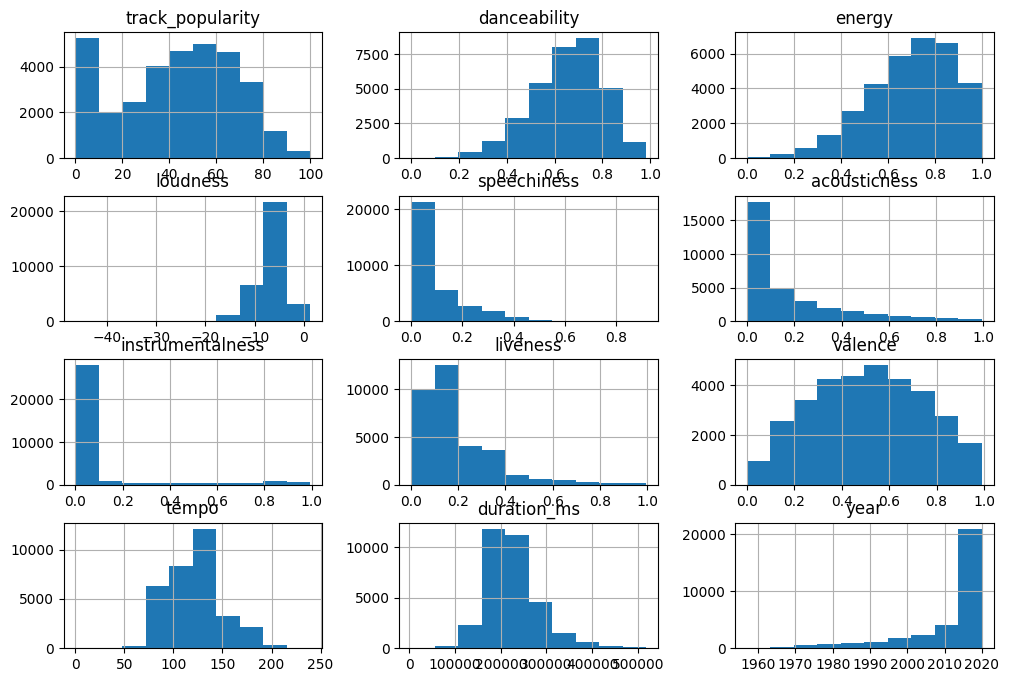

In [11]:
# Univariate analysis: Histograms for numeric columns
songs.hist(figsize=(12, 8))
plt.show()



Note that most of our data comes from around 2015-2020 which makes sense since spotify really gained popularity around then. This makes our data classes a bit unbalanced, so we will need to take that into account when looking at the performance of our model.

Instrumentalness, liveness, acousticness, and speechiness are all right skewed.

Tempo, duration, valence, and popularity are all symmetrical.

Loudness, danceability, and energy are all left skewed.

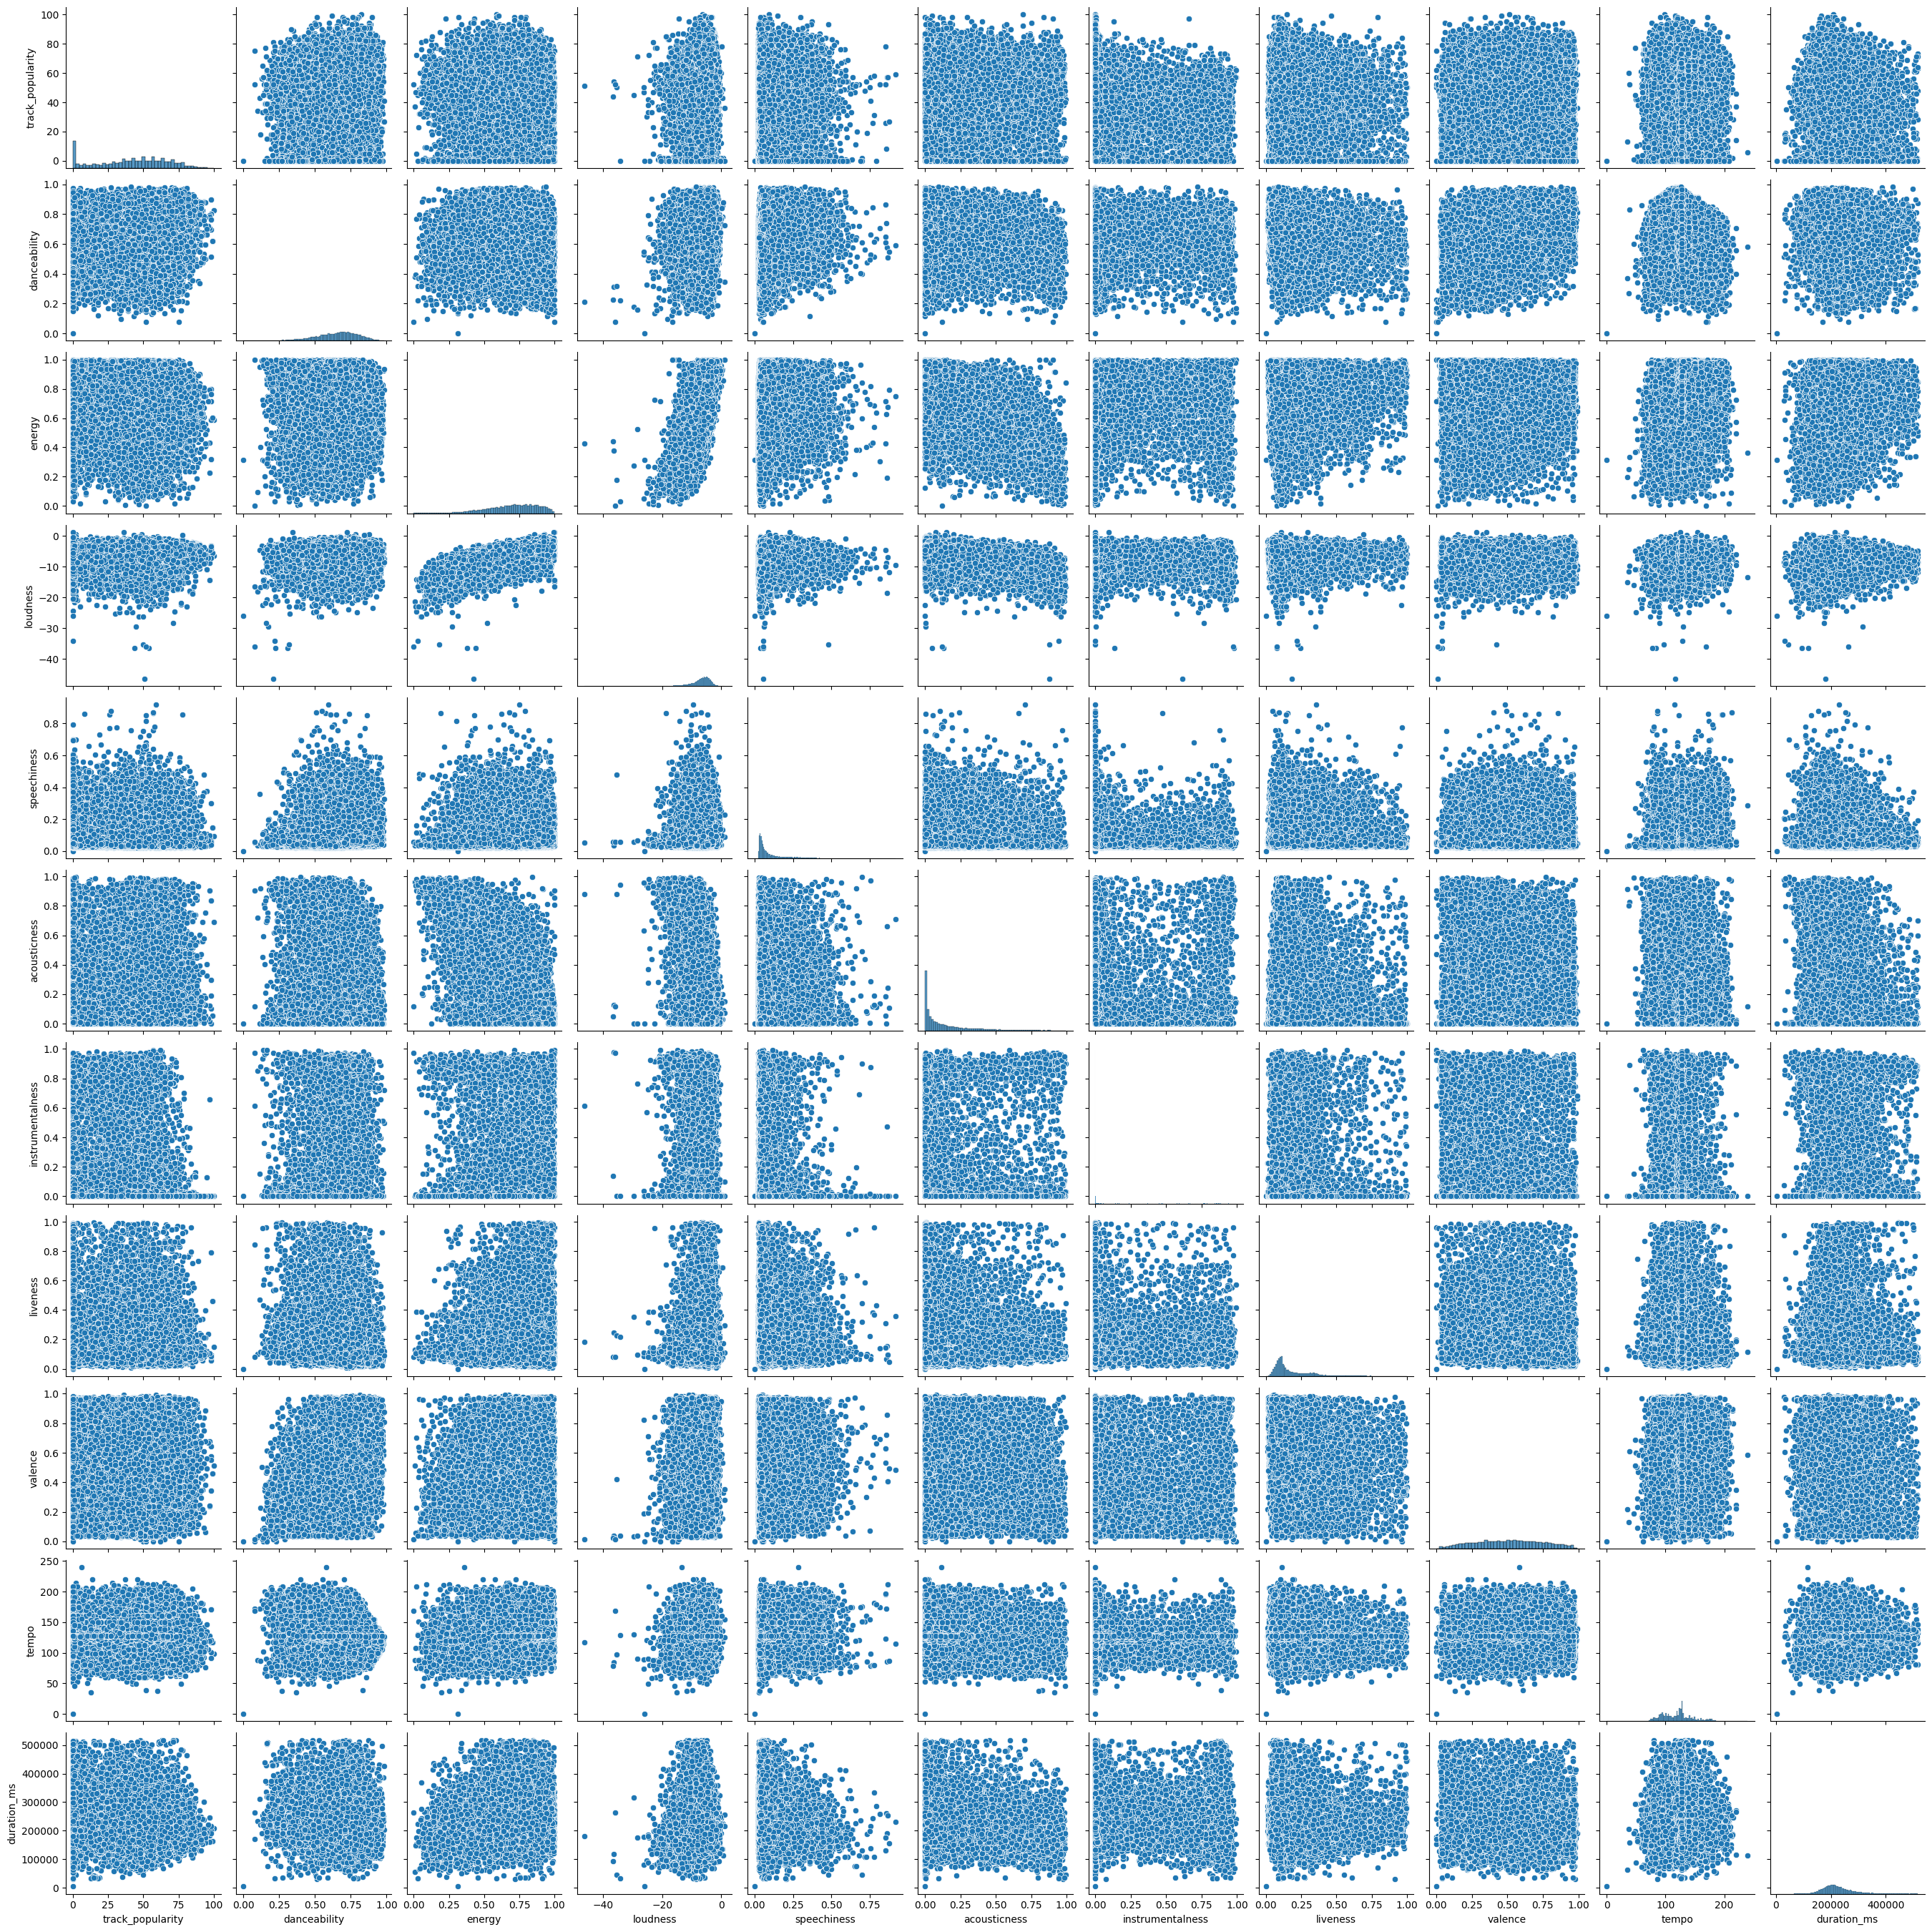

In [12]:
# Bivariate analysis: Pairplot for numeric columns
sns.pairplot(songs)
plt.show()



It doesn't appear as though there is any obvious multicollinearity. Potentially there could be some between energy and loudness, but it doesn't seem like there is much to worry about with that.

<ipython-input-13-571e8b523daa>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = dfsongs.corr()


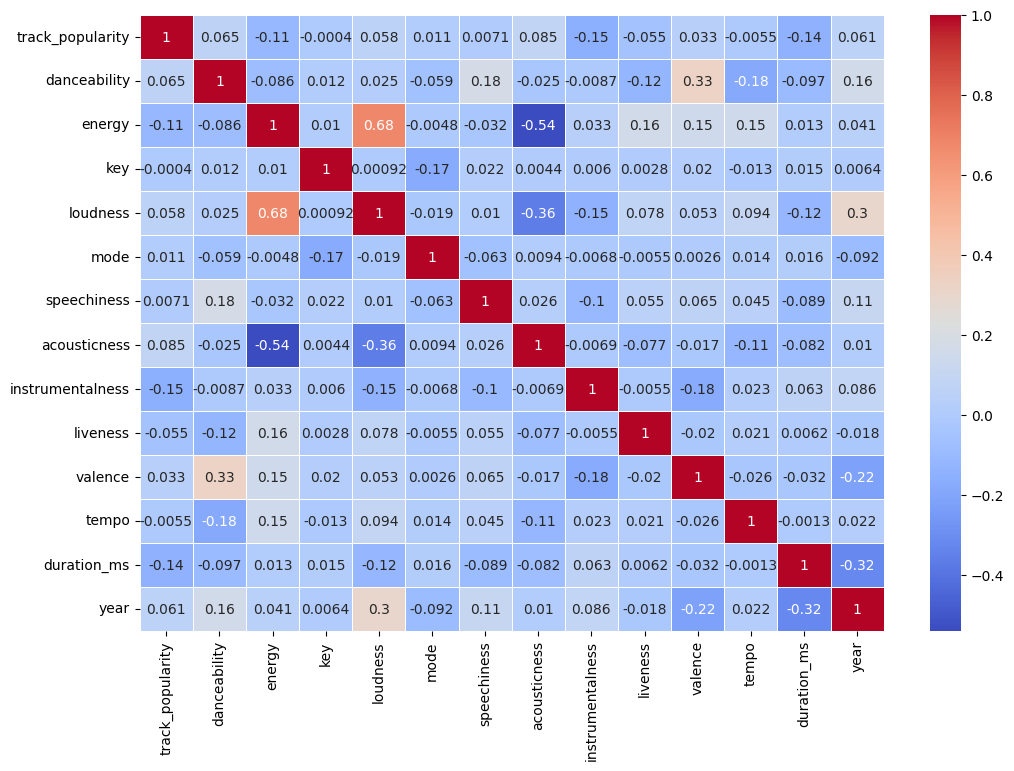

In [13]:
# Bivariate analysis: Heatmap for correlation matrix
correlation_matrix = dfsongs.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.show()



This plot emphasizes what we were already assuming, that there is not really much multicollinearity to worry about. Acouticness and energy have a bit of a relationship in addition to loudness and acousticness, but noting it seems like we should worry about.

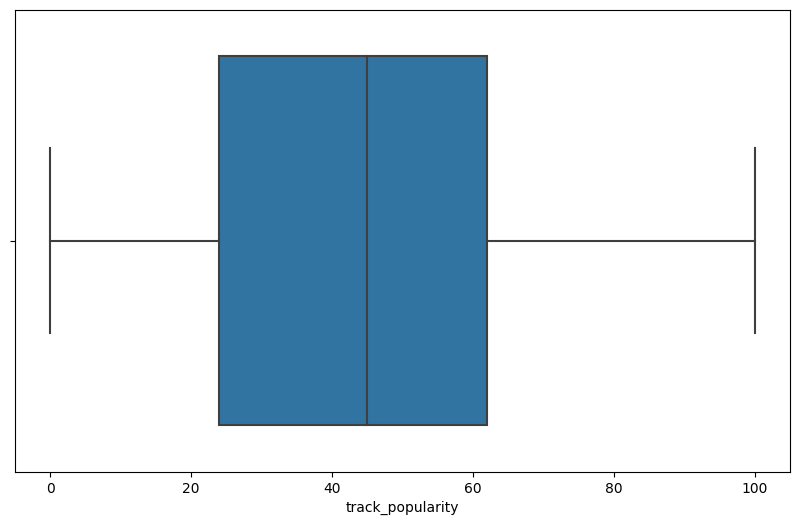

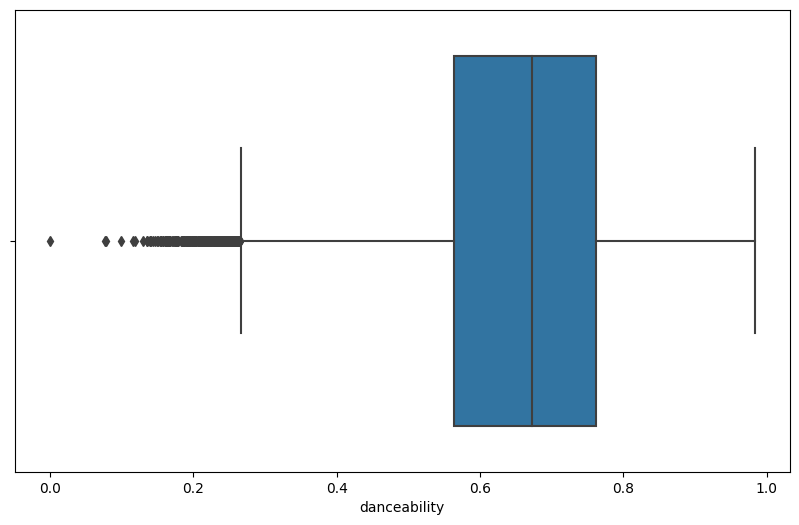

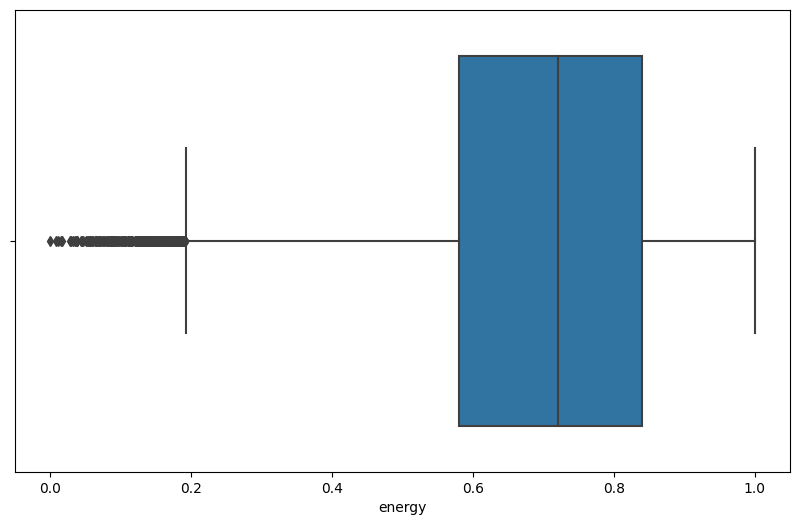

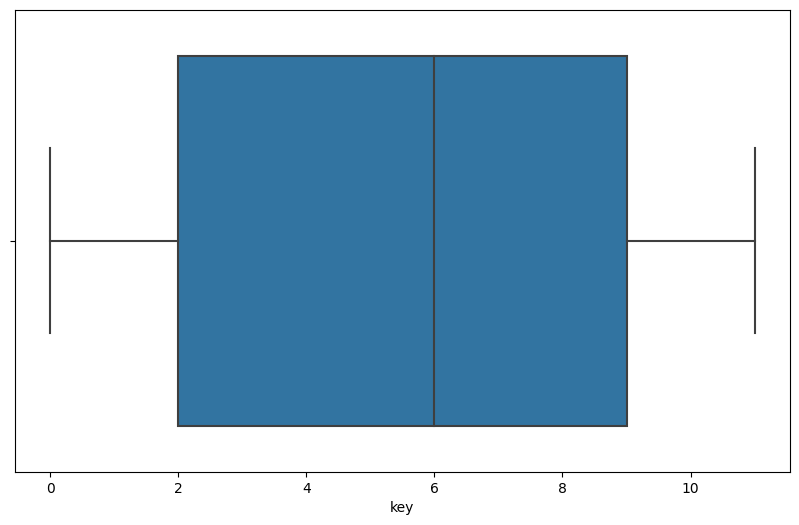

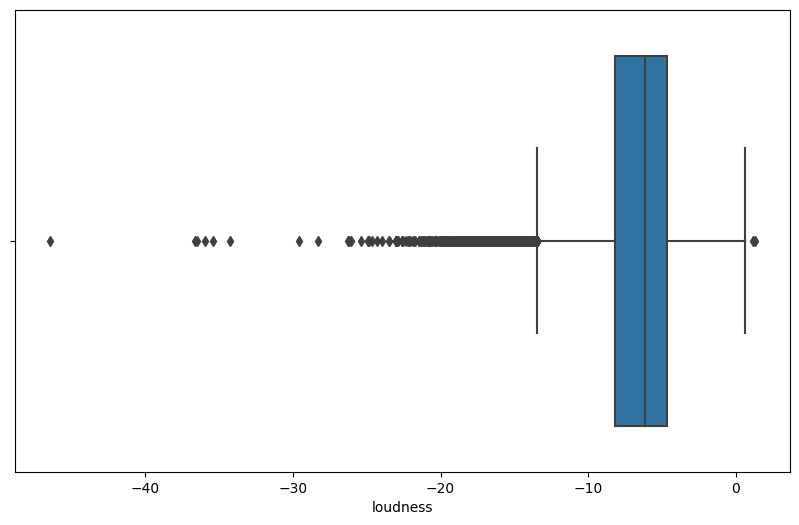

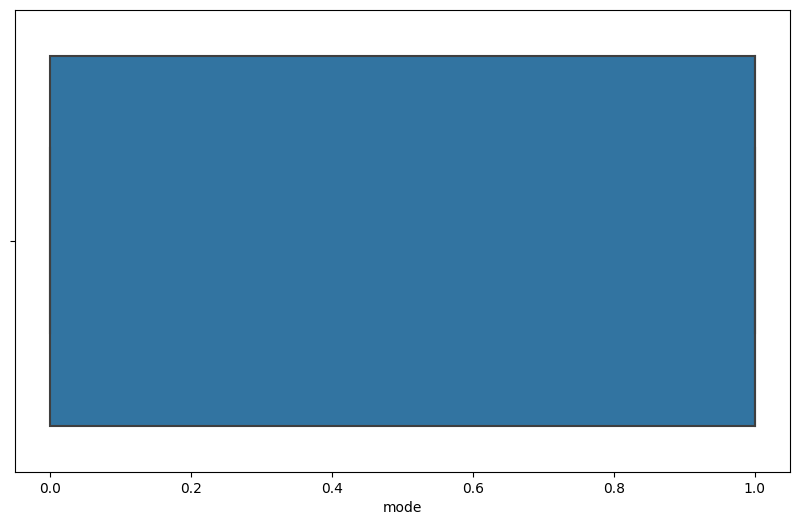

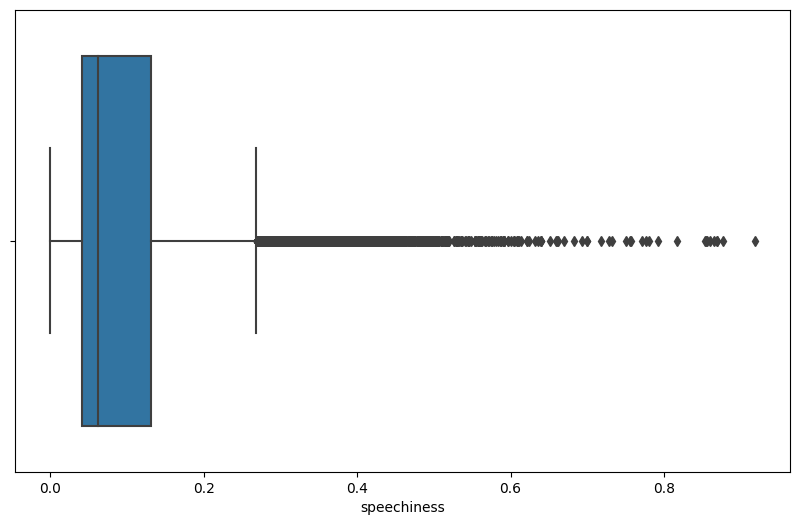

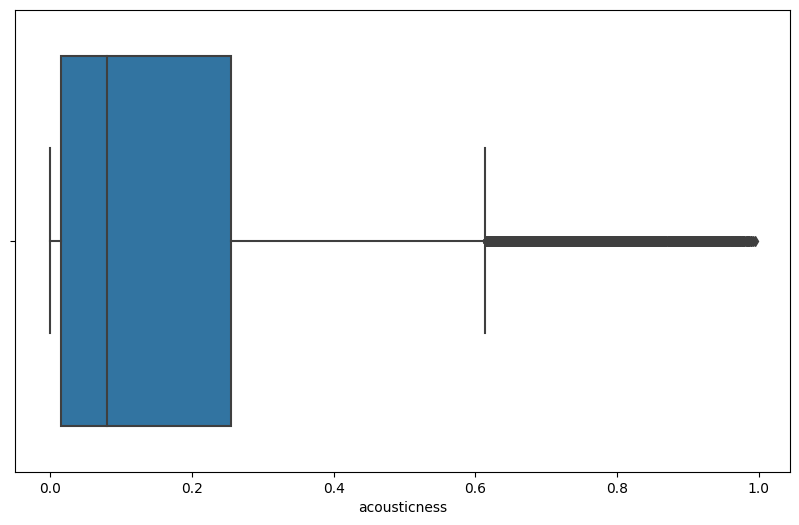

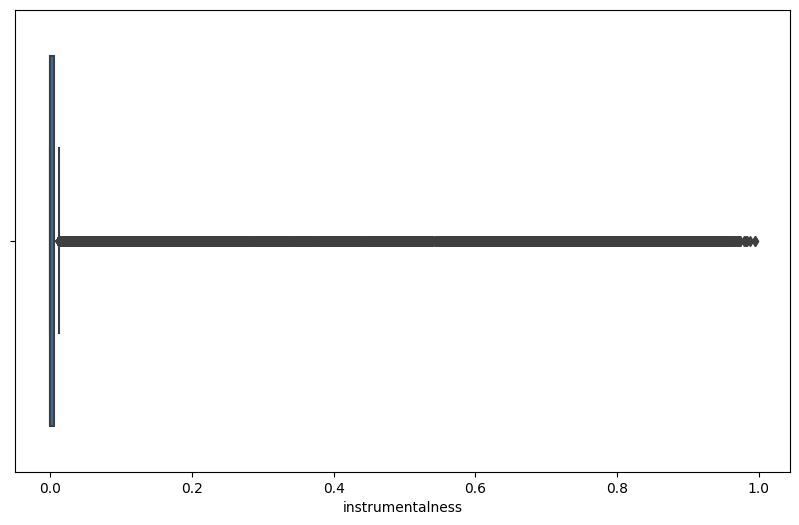

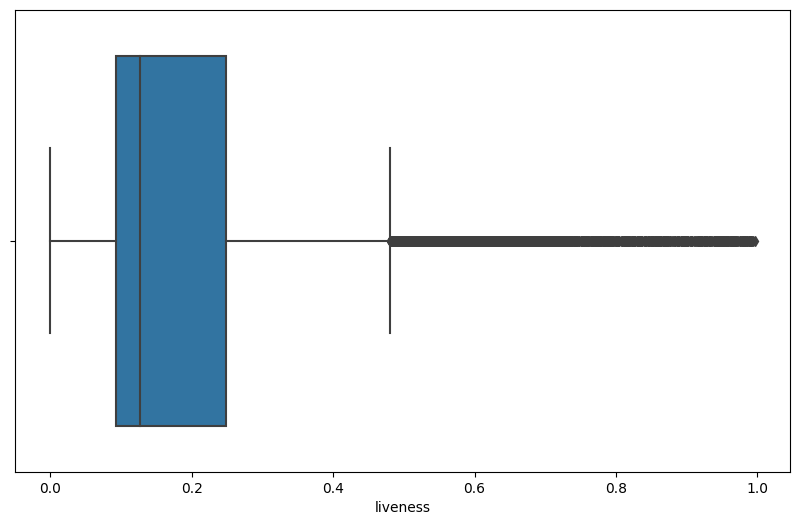

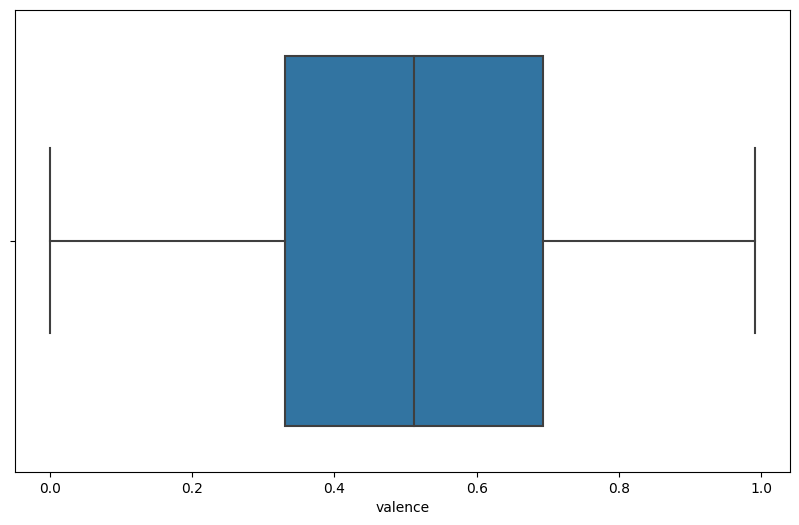

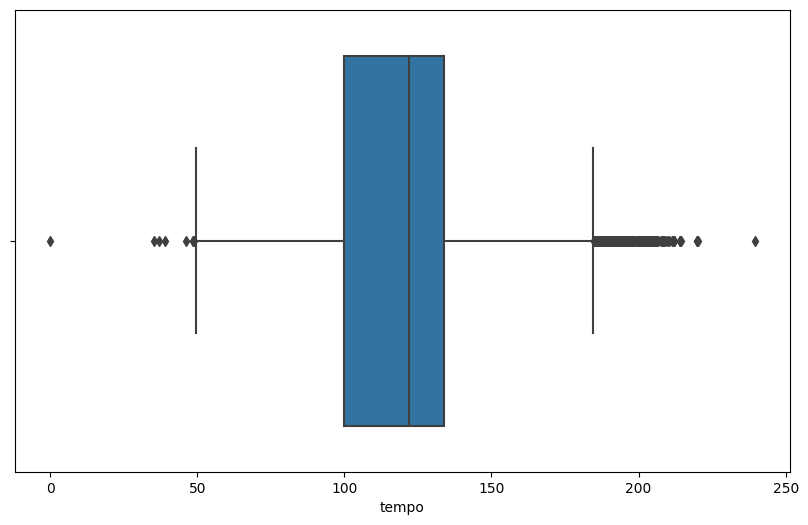

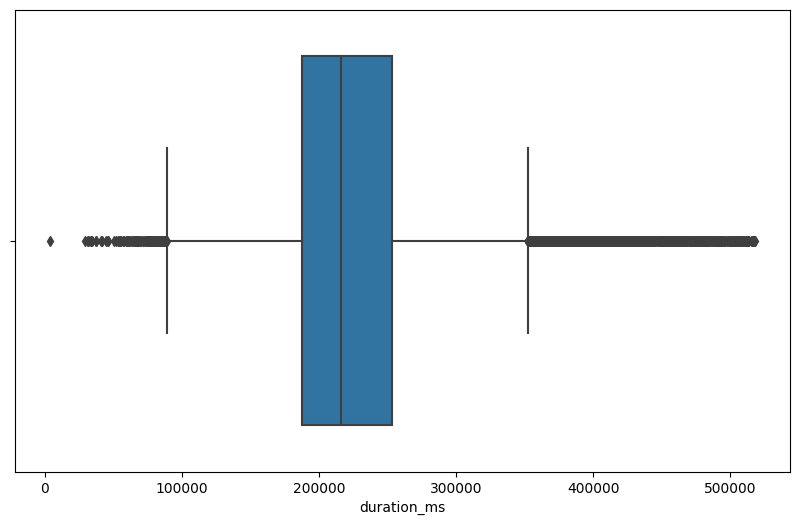

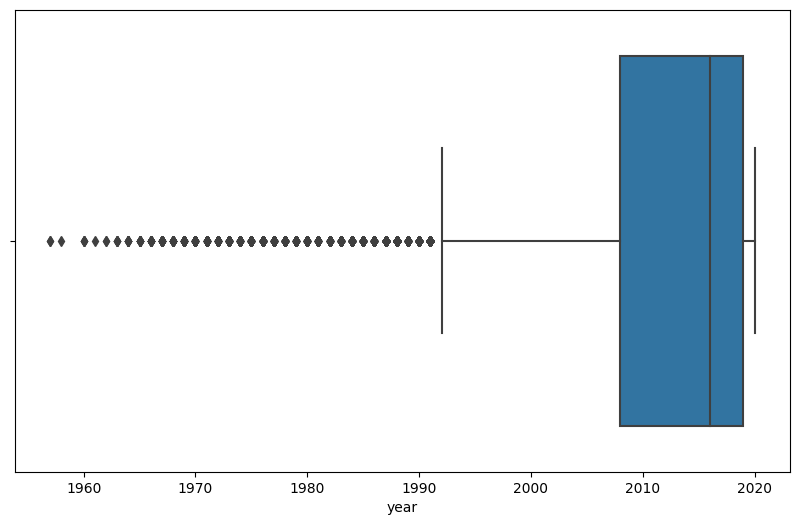

In [14]:
# Boxplot to identify outliers in numeric columns
for column in dfsongs.select_dtypes(include='number').columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column, data=dfsongs)
    plt.show()

These boxplots further cement what we learned about the variables from the histogram matrix.

# Analysis

# With Popularity as the Response Variable

## Popularity Predictor

In [13]:
# Separate features and target variable
X = songs[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence',
           'tempo', 'duration_ms']]

y = songs['track_popularity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Make predictions on the test set
predictions = regressor.predict(X_test)

In [16]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 573.8863404449864


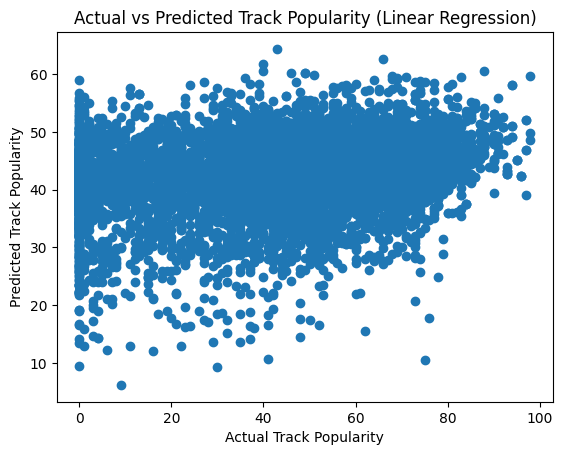

In [17]:
# Visualize predicted vs actual values
plt.scatter(y_test, predictions)
plt.xlabel('Actual Track Popularity')
plt.ylabel('Predicted Track Popularity')
plt.title('Actual vs Predicted Track Popularity (Linear Regression)')
plt.show()

In [18]:
# Ridge Regression
# alpha values
alphas = np.arange(0.1, 1.1, 0.1)

# Create a dictionary with alpha values
param_grid = {'alpha': alphas}

# Initialize Ridge regression model
ridge = Ridge()

# Perform grid search with cross-validation
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best alpha value
best_alpha = grid_search.best_params_['alpha']

# Best alpha is evaluated to be 1.0


In [19]:
# build the ridge regression
ridge_regressor = Ridge(alpha=best_alpha)
ridge_regressor.fit(X_train, y_train)

# Make predictions on the test set
predictions = ridge_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error on Test Set: {mse}')

Mean Squared Error on Test Set: 573.8705277995518


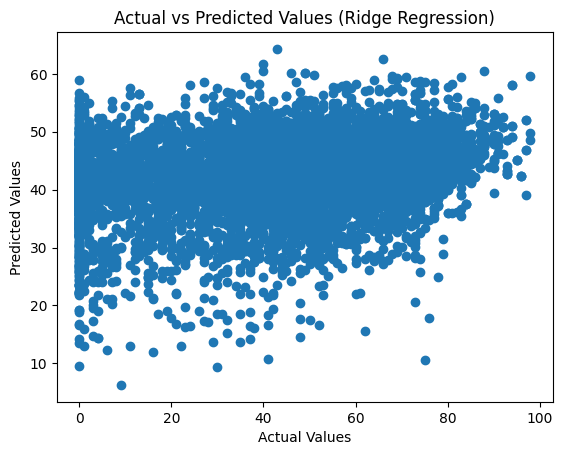

In [20]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Ridge Regression)')
plt.show()

### Random Forest Regressor

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
}

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_regressor, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_


Mean Squared Error on Test Set: 447.0049135285975


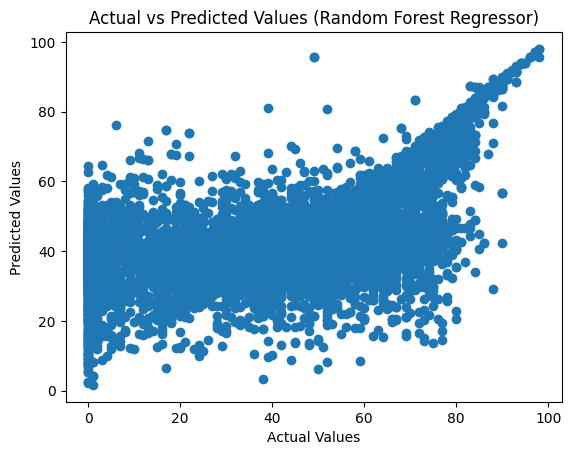

In [22]:
# Train the model with the best hyperparameters on the entire training set
# best params: max_depth = None, n_estimators = 150)
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
predictions = best_rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error on Test Set: {mse}')

# Visualize the predicted vs actual values
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest Regressor)')
plt.show()


This plot seems to show that when you have actual values above 40, they are typically better predicted than actual values below 40. I think this comes from having so many data points that are all very different in the below 40 range since most of the older music hasn't had the same popularity as newer music through Spotify, but there are still many different types of music in that older group. In addition, the MSE for this model is the lowest out of all the regression models I built, so this is the preferred method for predicting song popularity.

# With Playlist Genre as the Response Variable

## Random Forest Genre Classifier

In [14]:
# New response variable
X = songs.drop(['playlist_genre', 'year'], axis=1)
y = songs['playlist_genre']

# Label encode the response variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_encoded = pd.get_dummies(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)




In [46]:
# Define the best hyperparameters
best_hyperparams = {
    'n_estimators': 150,
    'max_depth': None
}

# Initialize Random Forest Classifier with the best hyperparameters
rf_classifier = RandomForestClassifier(**best_hyperparams, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_classifier.predict(X_test)



In [47]:
# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1229
           1       1.00      1.00      1.00       983
           2       1.00      1.00      1.00      1079
           3       1.00      1.00      1.00      1075
           4       1.00      1.00      1.00      1160
           5       1.00      1.00      1.00      1040

    accuracy                           1.00      6566
   macro avg       1.00      1.00      1.00      6566
weighted avg       1.00      1.00      1.00      6566


Confusion Matrix:
[[1229    0    0    0    0    0]
 [   0  983    0    0    0    0]
 [   0    0 1079    0    0    0]
 [   0    0    0 1075    0    0]
 [   0    0    0    0 1160    0]
 [   0    0    0    0    0 1040]]


When looking at the classification report and the confusion matrix, the random forest classifier we built correctly predicted all of the testing data it was provided. This seems a bit suspicious to me, but each of the support groups are large. I will continue with some other methods to check the validity of these results.

## Gradient Boosting and SHAP

In [ ]:
# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Create a SHAP explainer object
explainer = shap.Explainer(gb_model)

# Calculate SHAP values for a set of observations (e.g., the first 100 samples)
shap_values = explainer.shap_values(X_test.iloc[:100, :])

# Visualize the SHAP values (summary plot)
shap.summary_plot(shap_values, X_test.iloc[:100, :])

The accuracy of this model is 1.0 this means that it can perfectly predict all of the genres based on the features of the song. This doesn't completely seem right to me. I would imagine this means that the model is overfitting. This code takes almost 2.5 hours to run on my computer, so computationally, it doesn't make sense to run it again.

## Genre Cluster

In [23]:
# Select features for clustering
features = songs.drop(['playlist_genre', 'year', 'track_name', 'playlist_name', 'playlist_subgenre'], axis=1)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Choose the number of clusters (you may need to experiment with this)
num_clusters = 5

# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
dfsongs['cluster'] = kmeans.fit_predict(features_scaled)


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` exp

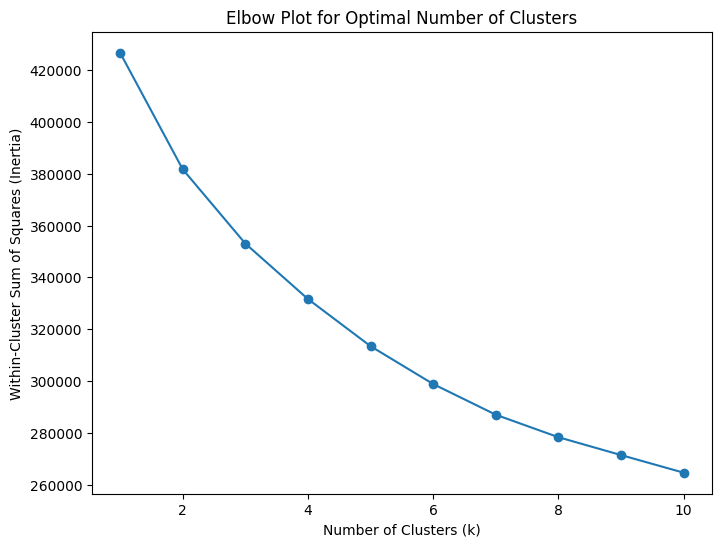

In [22]:
k_values = range(1,11)

# Fit k-means for each k and calculate inertia
inertia = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.show()


This elbow plot isn't super clear, but to me it does look like either 4 or 5 clusters is where the elbow on this plot is.

Songs per Cluster:
2    11806
1     8955
4     4893
3     4572
0     2602
Name: cluster, dtype: int64


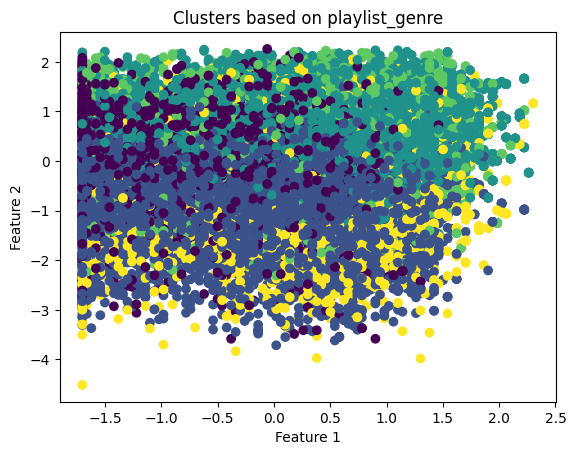

In [24]:
# Display the distribution of songs across clusters
cluster_counts = dfsongs['cluster'].value_counts()
print("Songs per Cluster:")
print(cluster_counts)

# Visualize the clusters (for 2D data)
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=dfsongs['cluster'], cmap='viridis')
plt.title('Clusters based on playlist_genre')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

This doesn't give a very visually pleasing view of the clusters. We should try a different approach to cluster the data that may be more interpretable. Amber suggested I try to use UMAP to see if that will be able to make some more distinct clusters.

## UMAP


In [34]:
# Assuming 'songs' is your DataFrame with the specified columns
columns_to_include = ['track_popularity', 'danceability', 'energy', 'loudness', 'speechiness',
                       'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms']

# Select the specified columns
numeric_features = songs[columns_to_include]

# Standardize the numeric features
scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)





n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


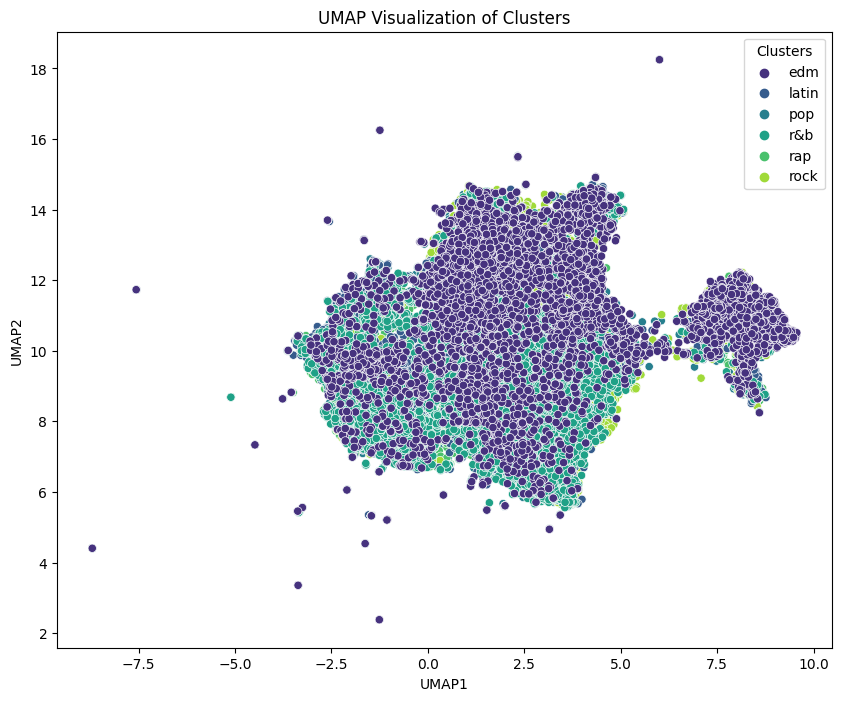

In [38]:
# Apply UMAP
umap_result = umap.UMAP(n_neighbors=50, min_dist = 0.05, n_components=2, random_state=42).fit_transform(numeric_features_scaled)

# Plot UMAP results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=songs['playlist_genre'], palette='viridis', legend='full')
plt.title('UMAP Visualization of Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Clusters', loc='best')
plt.show()

The above scatterplot of genres didn't do a much better job of splitting these into groups. After trying many different vales for neighbors and for min_dist, the above plot is the most defined the clusters became. This leads to the belief that song statistics are not enough to be able to understand what a song's genre is. There are more different variables and factors out there that help distringuish genres.

# Conclusion

My overall conclusion from this whole analysis is that it is not very straightforward to use a song's stats to predict its genre, and it also is not very straightforward to use a song's information to predict its popularity. All around, my questions of interest were answered, but the answer to both of them is no. You cannot predict popularity or genre of a song based on its features.

This was honestly very surprising to me. I hypothesized that it wouldn't necessarily show through in smaller models, but that in more complex models, we would be able to notice how variables impacted popularity or genre. I was incorrect in my hypotheses and even though sometimes the more complex models did a better job with predicitons, the predictions were never accurate enough to trust in the future.